In [1]:
%reload_ext autoreload
%autoreload 2

from help_function import *
from RLE_handler_mod import _rle_decode_frame_mod, _parse_rle_header, _rle_decode_segment
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from shutil import copyfile
import cv2
import pandas as pd
import csv
import numpy as np
import IPython
import math
import copy
from timeit import default_timer as timer
import datetime
from PIL import Image
from IPython.display import Image as gifShow
import pickle


## Inspect files and update metadata 

In [2]:
input_folder = './sacco/'
metadata_path = './sacco/s3sync.csv'



metadata = update_metadata(metadata=pd.read_csv(metadata_path, header=0),
                           input_folder=input_folder,
                           metadata_path=metadata_path)

metadata.to_csv('./sacco/Clip_MetaData.csv', index=False)

1/732 BRVI49BAMEINLA3C.dcm: has no transformation - size:  (84, 600, 800, 3) 0-255 YBR_FULL_422
2/732 DIFR40BAMEINLA3C_protesi mitralica.dcm: has no transformation - size:  (91, 600, 800, 3) 0-255 YBR_FULL_422
3/732 GRAL43BAMEINLA3C.dcm: has no transformation - size:  (93, 480, 854, 3) 0-255 YBR_FULL_422
4/732 GRAL43BAMEINLALAX.dcm: has no transformation - size:  (82, 480, 854, 3) 0-255 YBR_FULL_422
5/732 MOAN71BAINLALAX.dcm: has no transformation - size:  (72, 708, 1016, 3) 0-255 YBR_FULL_422
6/732 MOAN71BAMEANLA4C.dcm: has no transformation - size:  (72, 708, 1016, 3) 0-255 YBR_FULL_422
7/732 MOAN71BAMEINLA3C.dcm: has no transformation - size:  (74, 708, 1016, 3) 0-255 YBR_FULL_422
8/732 PAEM45BAMEINLA3C_verifica qualità.dcm: has no transformation - size:  (73, 600, 800, 3) 0-255 YBR_FULL_422
9/732 SIPA47BAINLALAX.dcm: has no transformation - size:  (108, 480, 854, 3) 0-255 YBR_FULL_422
10/732 SIPA47BAMEINLA3C_verifica qualità.dcm: has no transformation - size:  (126, 480, 854, 3) 

In [2]:
metadata = pd.read_csv('./sacco/Clip_MetaData.csv')

In [4]:
# check differences between Import OK vs Failed

display(metadata.groupby(['Import_Status']).size().to_frame().add_prefix('X_').rename(columns={'X_0': 'count'}))
display(metadata.groupby(['Import_Status', 'SamplesPerPixel', 'PhotometricInterpretation', 'PlanarConfiguration',
                  'BitsAllocated', 'covid', 'akinetic', 'Transform']).size().to_frame().add_prefix('X_').rename(columns={'X_0': 'count'}))

,count
Import_Status,
Failed,55
OK,677


count
Import_Status SamplesPerPixel PhotometricInterpretation PlanarConfiguration BitsAllocated covid akinetic Transform       
Failed        3               YBR_FULL                  1                   8             0     0        None          40
                                                                                                1        None          15
OK            1               PALETTE COLOR             0                   8             1     0        None           7
              3               RGB                       0                   8             1     0        None          30
                                                                                                1        None          17
                              YBR_FULL_422              0                   8             0     0        None         330
                                                                                                1        None         188
                                                                                          1     0        None         102
                                                                                                1        None           3

In [5]:
# check distribution of diagnosis

display(metadata.groupby(['covid']).size().to_frame().add_prefix('X_').rename(columns={'X_0': 'count'}))
display(metadata.groupby(['akinetic']).size().to_frame().add_prefix('X_').rename(columns={'X_0': 'count'}))
display(metadata.groupby(['covid', 'Import_Status']).size().to_frame().add_prefix('X_').rename(columns={'X_0': 'count'}))
display(metadata.groupby(['akinetic', 'Import_Status']).size().to_frame().add_prefix('X_').rename(columns={'X_0': 'count'}))

,count
covid,
False,573
True,159


,count
akinetic,
False,509
True,223


count
covid Import_Status       
False Failed            55
      OK               518
True  OK               159

count
akinetic Import_Status       
False    Failed            40
         OK               469
True     Failed            15
         OK               208

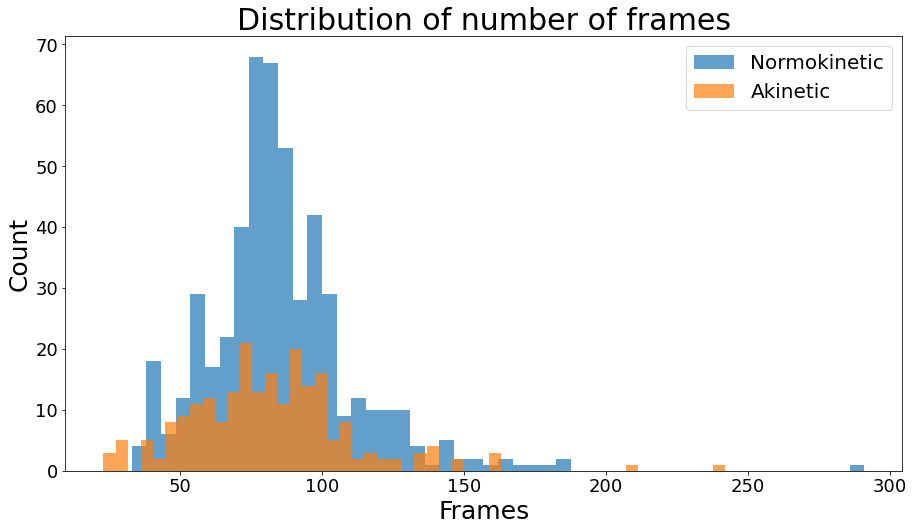

In [3]:
# fig, ax = plt.subplots(figsize=(15,8))
# for i, d in metadata.groupby('akinetic'):
#     d['NumberOfFrames'].hist(alpha=0.7, ax=ax, label='Akinetic' if i ==1 else 'Normokinetic', bins = 50)
# # metadata.groupby("akinetic").NumberOfFrames.hist(bins = 50, ax=ax)
# plt.title('Distribution of number of frames', size= 30)
# plt.xlabel('Frames', size = 25)
# plt.ylabel('Count', size = 25)
# ax.grid(False)
# ax.tick_params(labelsize=18)
# plt.legend(fontsize = 20)
# plt.show()
# fig.savefig('pp.png')

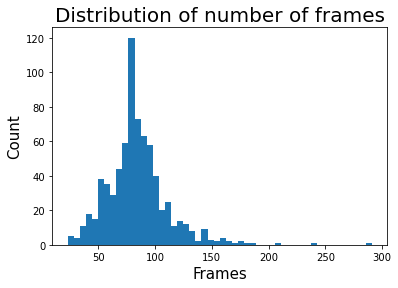



Average number of frames: 84.29781420765028
Range of number of frames: 23 - 291
Increasing bottom 20 number of frames: [23, 24, 26, 28, 28, 29, 30, 31, 33, 34, 37, 37, 38, 38, 39, 39, 39, 39, 39, 39]
Decreasing top 20 number of frames: [291, 242, 208, 185, 183, 178, 176, 170, 166, 165, 160, 159, 159, 159, 154, 152, 150, 149, 147, 146]


In [19]:
# check number of frames

plt.hist(metadata.NumberOfFrames.values, 50, density = False)
plt.title('Distribution of number of frames', size= 20)
plt.xlabel('Frames', size = 15)
plt.ylabel('Count', size = 15)
plt.show()
print('\n\nAverage number of frames:', metadata.NumberOfFrames.mean())
print('Range of number of frames:', metadata.NumberOfFrames.min(), '-', metadata.NumberOfFrames.max())
print('Increasing bottom 20 number of frames:', sorted(metadata.NumberOfFrames, reverse=False)[:20])
print('Decreasing top 20 number of frames:', sorted(metadata.NumberOfFrames, reverse=True)[:20])

In [7]:
# check for duplicated filename

dupl_df = metadata.groupby(['filename']).size().to_frame().add_prefix('X_').rename(columns={'X_0': 'count'})
dupl_df = dupl_df[dupl_df['count'] > 1]
if dupl_df.shape[0] > 0:
    print('Duplicates found for:')
    display(dupl_df)
    display(metadata[metadata.filename.isin(dupl_df.index.values)].sort_values(by=['filename']))


Duplicates found for:


,count
filename,
BRSE39ACIBAMEIN2C.dcm,2
FRRO54ACIBAMEIN2C.dcm,2
WAME62_2C.dcm,2
WAME62_3C.dcm,2
WAME62_4C.dcm,2
WAME62_LAX.dcm,2


,folder,index,local_path,filename,last_modified,size,patient,covid,akinetic,Import_Status,...,CineRate,EffectiveDuration,FrameTime,FrameDelay,HeartRate,ActualFrameDuration,RWaveTimeVector,PatientName,PatientSex,PatientBirthDate
262,2020-07-01-acinesia-inferiore,eco-scan-cardio/2020-07-01-acinesia-inferiore/...,/home/shared/datasets/defeatcovid19/sacco/eco-...,BRSE39ACIBAMEIN2C.dcm,2020-07-11 09:58:31+00:00,7734972,BRSE39,False,True,OK,...,0,0.000000,20.067000,0.0,79,0,0,BRENNA^SERGIO,M,19390128.0
306,2020-07-20-acinesia inferiore 2_MC,eco-scan-cardio/2020-07-20-acinesia inferiore ...,/home/shared/datasets/defeatcovid19/sacco/eco-...,BRSE39ACIBAMEIN2C.dcm,2020-07-22 17:01:07+00:00,16622382,BRSE39,False,True,Failed,...,25,2.440000,40.355191,0.0,81,23,0,BRENNA^SERGIO,M,19390128.0
268,2020-07-01-acinesia-inferiore,eco-scan-cardio/2020-07-01-acinesia-inferiore/...,/home/shared/datasets/defeatcovid19/sacco/eco-...,FRRO54ACIBAMEIN2C.dcm,2020-07-11 09:58:34+00:00,4509240,FRRO54,False,True,OK,...,30,1.800000,33.672840,0.0,67,14,0,FRASCA^ROSARIO,M,19540325.0
310,2020-07-20-acinesia inferiore 2_MC,eco-scan-cardio/2020-07-20-acinesia inferiore ...,/home/shared/datasets/defeatcovid19/sacco/eco-...,FRRO54ACIBAMEIN2C.dcm,2020-07-22 17:01:08+00:00,4137434,FRRO54,False,True,OK,...,30,1.600000,33.472222,0.0,75,16,0,FRASCA^ROSARIO,M,19540325.0
300,2020-07-17-pazienti-covid,eco-scan-cardio/2020-07-17-pazienti-covid/WAME...,/home/shared/datasets/defeatcovid19/sacco/eco-...,WAME62_2C.dcm,2020-07-30 13:52:34+00:00,42733982,WAME62,True,True,OK,...,28,2.971538,0.000000,0.0,0,0,0,Wangpa 127R^Meiling,NaN,19620624.0
725,2020-08-07-covid-normali,eco-scan-cardio/2020-08-07-covid-normali/WAME6...,/home/shared/datasets/defeatcovid19/sacco/eco-...,WAME62_2C.dcm,2020-08-10 14:08:25+00:00,42735086,WAME62,True,False,OK,...,28,2.971538,0.000000,0.0,0,0,0,WANG^MEILING,F,19620624.0
301,2020-07-17-pazienti-covid,eco-scan-cardio/2020-07-17-pazienti-covid/WAME...,/home/shared/datasets/defeatcovid19/sacco/eco-...,WAME62_3C.dcm,2020-07-30 13:52:35+00:00,41637566,WAME62,True,True,OK,...,28,2.971463,0.000000,0.0,0,0,0,Wangpa 127R^Meiling,NaN,19620624.0
726,2020-08-07-covid-normali,eco-scan-cardio/2020-08-07-covid-normali/WAME6...,/home/shared/datasets/defeatcovid19/sacco/eco-...,WAME62_3C.dcm,2020-08-10 14:08:25+00:00,41638666,WAME62,True,False,OK,...,28,2.971463,0.000000,0.0,0,0,0,WANG^MEILING,F,19620624.0
302,2020-07-17-pazienti-covid,eco-scan-cardio/2020-07-17-pazienti-covid/WAME...,/home/shared/datasets/defeatcovid19/sacco/eco-...,WAME62_4C.dcm,2020-07-30 13:52:36+00:00,35817614,WAME62,True,True,OK,...,26,2.963583,0.000000,0.0,0,0,0,Wangpa 127R^Meiling,NaN,19620624.0
730,2020-08-07-covid-normali,eco-scan-cardio/2020-08-07-covid-normali/WAME6...,/home/shared/datasets/defeatcovid19/sacco/eco-...,WAME62_4C.dcm,2020-08-10 14:08:34+00:00,36321012,WAME62,True,False,OK,...,26,3.001498,0.000000,0.0,0,0,0,WANG^MEILING,F,19620624.0


## Convert images with Import_Status == 'OK'

In [9]:
input_folder = './sacco/'
output_PNG_folder = './sacco/PNG/Converted'
output_PKL_folder = './sacco/PKL/raw_images'


metadata_by_frame, filename_list = convert_DICOM(metadata_df=metadata[metadata.Import_Status == 'OK'],
                                                 filename_list = [], # used to trace duplicates
                                                 input_folder=input_folder,
                                                 output_PNG_folder=output_PNG_folder,
                                                 output_PKL_folder=output_PKL_folder)

metadata_by_frame.to_csv('./sacco/Frame_MetaData.csv', index=False)

295 eco-scan-cardio/2020-07-20-acinesia inferiore 2_MC/FRRO54ACIBAMEIN2C.dcm : duplicated filename, changed in FRRO54ACIBAMEIN2C_BIS.dcm
670 eco-scan-cardio/2020-08-07-covid-normali/WAME62/WAME62_2C.dcm : duplicated filename, changed in WAME62_2C_BIS.dcm
671 eco-scan-cardio/2020-08-07-covid-normali/WAME62/WAME62_3C.dcm : duplicated filename, changed in WAME62_3C_BIS.dcm
675 eco-scan-cardio/2020-08-07-covid-normali/WAME62/WAME62_4C.dcm : duplicated filename, changed in WAME62_4C_BIS.dcm
676 eco-scan-cardio/2020-08-07-covid-normali/WAME62/WAME62_LAX.dcm : duplicated filename, changed in WAME62_LAX_BIS.dcm

Total elapsed time: 1:55:57


## ~~Manually convert failed to import~~

In [26]:
# zip_file = './sacco/000_Manual_Convert.zip'
# file_folder = './sacco'

# manual_conv = copy.deepcopy(metadata[metadata.Import_Status == 'Failed'])#.loc[[306,325]]
# manual_conv['filename_orig'] = manual_conv['filename']
# with ZipFile(os.path.join(file_folder, os.path.basename(zip_file)), 'w') as zipp:
#     for i, row in manual_conv.iterrows():
#         path = row['index']
#         filename = row['filename']
#         # rename duplicated filename (only in zip file)
#         if filename in filename_list:
#             new_filename = filename.split('.')[0] + '_BIS.dcm'
#             manual_conv['filename'].loc[i] = new_filename
#             new_path = path.replace(filename, new_filename)
#             print(i, path, ': duplicated filename, changed in', new_filename)
#             os.rename(os.path.join(file_folder, path), os.path.join(file_folder, new_path))
#             zipp.write(os.path.join(file_folder, new_path))
#             os.rename(os.path.join(file_folder, new_path), os.path.join(file_folder, path))
#         else:
#             zipp.write(os.path.join(file_folder, path))
            
# print('\n\n\nFiles with Failed Import found:', manual_conv.shape[0])
# print('\nZipped in ', zip_file)

/home/alessandro/.conda/envs/convert-echo/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


306 eco-scan-cardio/2020-07-20-acinesia inferiore 2_MC/BRSE39ACIBAMEIN2C.dcm : duplicated filename, changed in BRSE39ACIBAMEIN2C_BIS.dcm



Files with Failed Import found: 55

Zipped in  ./sacco/000_Manual_Convert.zip


In [27]:
# # read from uploaded folder and convert to PNG and change name accordingly to metadata_by_frame
# manual_folder = './sacco/manually_extracted'
# dest_folder = './sacco/PNG/Converted'



# # check expected total number of files
# files_list = sorted([i for i in os.listdir(manual_folder) if i.endswith('jpg')])
# if len(files_list) != manual_conv.NumberOfFrames.sum():
#     raise ValueError('Number of uploaded frames doesn\'t match the expected one: '+str(len(files_list))+
#                      ' vs '+str(manual_conv.NumberOfFrames.sum()))
# tot_files = len(files_list)
    
# # convert frames
# start = timer()
# for i, framename in enumerate(files_list):
    
#     print(i+1, '/', tot_files, end = '\r')
#     filename = framename.split('_Frame')[0]
#     frame_number = int(framename.split('_Frame')[1].split('.jpg')[0])-1
#     new_framename = filename + '_' + "{:03d}".format(frame_number) + '.png'
#     new_frame_path = os.path.join(dest_folder, new_framename)
#     Image.open(os.path.join(manual_folder, framename)).save(new_frame_path)
    
#     row = manual_conv[manual_conv.filename == filename+'.dcm']
#     row_to_add = copy.deepcopy(row[['folder', 'index', 'filename_orig', 'filename', 'Import_Status'] + col_to_keep])
# #     row_to_add['filename'] = filename
#     row_to_add['index_frame'] = new_frame_path
#     row_to_add['filename_frame'] = new_framename
#     row_to_add['Frame_ID'] = frame_number
#     metadata_by_frame=metadata_by_frame.append(row_to_add)
# print('\n Total elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))


# metadata_by_frame = metadata_by_frame.sort_values(by=['filename', 'Frame_ID']).reset_index(drop=True)
# metadata_by_frame.to_csv('./sacco/Frame_MetaData.csv', index=False)

3296 / 3296
 Total elapsed time: 0:03:27


## Edit pydicom function to fix conversion of images with Import_Status == 'Failed'

In [11]:
# edit function and save original for later

original_function = copy.deepcopy(dicom.pixel_data_handlers.rle_handler._rle_decode_frame)
dicom.pixel_data_handlers.rle_handler._rle_decode_frame = _rle_decode_frame_mod

In [12]:
input_folder = './sacco/'
output_PNG_folder = './sacco/PNG/Converted'
output_PKL_folder = './sacco/PKL/raw_images'


metadata = pd.read_csv('./sacco/Clip_MetaData.csv')
metadata_by_frame = pd.read_csv('./sacco/Frame_MetaData.csv')
metadata_by_frame_failed, _ = convert_DICOM(metadata_df=metadata[metadata.Import_Status == 'Failed'],
                                     filename_list = filename_list, # used to trace duplicates
                                     input_folder=input_folder,
                                     output_PNG_folder=output_PNG_folder,
                                     output_PKL_folder=output_PKL_folder)

metadata_by_frame = metadata_by_frame.append(metadata_by_frame_failed)
metadata_by_frame.to_csv('./sacco/Frame_MetaData.csv', index=False)

14 eco-scan-cardio/2020-07-20-acinesia inferiore 2_MC/BRSE39ACIBAMEIN2C.dcm : duplicated filename, changed in BRSE39ACIBAMEIN2C_BIS.dcm
55 / 55
Total elapsed time: 0:04:05


In [13]:
# replace original function

dicom.pixel_data_handlers.rle_handler._rle_decode_frame = original_function

## Update metadata filename with duplicated ones

In [14]:
metadata = metadata.rename(columns={"filename": "filename_orig"})
metadata = pd.merge(metadata, metadata_by_frame[['index', 'filename', 'index_pickle']].drop_duplicates(), left_on='index', right_on='index')
column_reshape = ['folder', 'index', 'index_pickle', 'local_path', 'filename_orig', 'filename']
metadata = metadata[column_reshape + [col for col in metadata.columns if col not in column_reshape]]

metadata.to_csv('./sacco/Clip_MetaData.csv', index=False)

## Check if conversion matches expected frames

In [15]:
conv_folder = './sacco/PNG/Converted'
PKL_folder = './sacco/PKL/raw_images'


files_list = sorted([i for i in os.listdir(conv_folder)])
pickle_list = sorted([i for i in os.listdir(PKL_folder)])
metadata = pd.read_csv('./sacco/Clip_MetaData.csv')
metadata_by_frame = pd.read_csv('./sacco/Frame_MetaData.csv')
error=False
if metadata_by_frame.filename.nunique() != metadata.shape[0]:
    print('\n\n########### warning, expected number of filename doesn\'t match number of DICOM files', metadata_by_frame.filename.nunique(),
          'vs', metadata.shape[0], '\n\n')
    error=True
if metadata_by_frame.shape[0] != metadata.NumberOfFrames.sum():
    print('\n\n########### warning, rows of metadata_by_frame doesn\'t match sum(NumberOfFrames)', metadata_by_frame.shape[0],
          'vs', metadata.NumberOfFrames.sum(), '\n\n')
    error=True
if len(files_list) != metadata_by_frame.shape[0]:
    print('\n\n########### warning, total number of frames doesn\'t match expected one', len(files_list),
          'vs', metadata_by_frame.shape[0], '\n\n')
    error=True
    
if len(pickle_list) != metadata.shape[0]:
    print('\n\n########### warning, total number pickle files doesn\'t match expected one', len(pickle_list),
          'vs', metadata.shape[0], '\n\n')
    error=True

for filename in metadata_by_frame.filename.unique():
    
    frame_df = metadata_by_frame[metadata_by_frame.filename == filename]
    metadata_row = metadata[metadata['index'] == frame_df['index'].unique()[0]]
    files_found = set(frame_df.filename_frame.values) & set(files_list)
    if len(files_found) != frame_df.shape[0]:
        print(filename, 'expected frames:', frame_df.shape[0], 'actual images:', len(files_found))
        error=True
    
if error==False:
    print('\nEverything OK\n')


Everything OK



## Visualize samples

In [21]:
sample_folder = './sacco/sample_and_check/frame_sample/'

metadata = pd.read_csv('./sacco/Clip_MetaData.csv')
metadata_by_frame = pd.read_csv('./sacco/Frame_MetaData.csv')

plot_frame_sample(metadata, metadata_by_frame, save_folder=sample_folder)


SyntaxError: invalid syntax (<ipython-input-21-139eac76ec21>, line 1)

## Understand if frame differences may be useful

In [42]:
# take one sample for each combination folder+Import_Status plus additional specific files
gif_folder = './sacco/GIF'
add_files = ['eco-scan-cardio/2020-07-24-sani/MOSY91/MOSY91_2C.dcm',  # colored one
             'eco-scan-cardio/2020-07-25-sani/MUSA52/MUSA52_4C.dcm',  # colored one
             'eco-scan-cardio/2020-07-17-pazienti-covid/CHVI74/CHVI74_3C.dcm'  # colored one
            ]



metadata = pd.read_csv('./sacco/Clip_MetaData.csv')
metadata_by_frame = pd.read_csv('./sacco/Frame_MetaData.csv')
sample_per_folder = metadata_by_frame[['folder', 'index', 'filename_orig', 'filename', 'Import_Status']].drop_duplicates() \
                    .groupby(['folder', 'Import_Status']).head(1).sort_values(by=['folder', 'Import_Status'])
add_rows = metadata_by_frame[metadata_by_frame['index'].isin(add_files)][
    ['folder', 'index', 'filename_orig', 'filename', 'Import_Status']].drop_duplicates()
sample_per_folder = sample_per_folder.append(add_rows).drop_duplicates().sort_values(by=['folder', 'Import_Status'])
gif_path_list = []
# create gif
for i, row in sample_per_folder.iterrows():
    gif_path = create_difference_GIF(row.filename, metadata, metadata_by_frame, save_folder = gif_folder, fig_x_size = 7)
    gif_path_list.append(gif_path)
# show gif
for path in gif_path_list:
    with open(path,'rb') as f:
        display(gifShow(data=f.read(), format='png'))

SyntaxError: invalid syntax (<ipython-input-42-6f0f0db11755>, line 2)

## Remove colored DICOM

Colored DICOM are colordoppler, including blood flux

In [16]:
filename_to_remove = ['eco-scan-cardio/2020-07-24-sani/MOSY91/MOSY91_2C.dcm',
                     'eco-scan-cardio/2020-07-25-sani/MUSA52/MUSA52_4C.dcm',
                     'eco-scan-cardio/2020-07-17-pazienti-covid/CHVI74/CHVI74_3C.dcm']

metadata.insert(0, 'keep', np.where(metadata['index'].isin(filename_to_remove), 'Remove', 'Keep'))
metadata_by_frame.insert(0, 'keep', np.where(metadata_by_frame['index'].isin(filename_to_remove), 'Remove', 'Keep'))

metadata.to_csv('./sacco/Clip_MetaData.csv', index=False)
metadata_by_frame.to_csv('./sacco/Frame_MetaData.csv', index=False)

## Create mask to isolate central "triangle"

In [17]:
mask_folder = './sacco/PKL/masks'
image_folder = './sacco/PKL/raw_images'

metadata = pd.read_csv('./sacco/Clip_MetaData.csv')
diff_to_try_log, mask_percentage_log = save_mask(metadata, image_folder=image_folder, mask_folder=mask_folder)

289 / 732
######### warning, mask is removing 85% of image
290 / 732
######### warning, mask is removing 85% of image
291 / 732
######### warning, mask is removing 85% of image
295 / 732
######### warning, mask is removing 85% of image
296 / 732
######### warning, mask is removing 85% of image
297 / 732
######### warning, mask is removing 85% of image
298 / 732
######### warning, mask is removing 85% of image
300 / 732
######### warning, mask is removing 85% of image
301 / 732
######### warning, mask is removing 85% of image
302 / 732
######### warning, mask is removing 85% of image
303 / 732
######### warning, mask is removing 85% of image
304 / 732
######### warning, mask is removing 85% of image
305 / 732
######### warning, mask is removing 85% of image
662 / 732
######### warning, mask is removing 85% of image
663 / 732
######### warning, mask is removing 85% of image
664 / 732
######### warning, mask is removing 85% of image
706 / 732
######### warning, mask is removing 85% of ima

In [19]:
# check mask in mask_percentage_log
perc_thresh = 85

mask_path_list = np.array([x for x in mask_percentage_log if x[1] >= perc_thresh])
rev_index = np.argsort([x[1] for x in mask_percentage_log if x[1] >= perc_thresh])[::-1]
mask_path_list = mask_path_list[rev_index]

fig, ax = plt.subplots(len(mask_path_list), 2, figsize=(10, 3 * len(mask_path_list)), sharey=False, sharex=False)
ax = ax.flatten()

for i, el in enumerate(mask_path_list):
    
    with open(el[3], 'rb') as handle:
        data_gray = pickle.load(handle)

    with open(el[4], 'rb') as handle:
        mask = pickle.load(handle)

    ax[2*i].imshow(data_gray[0], cmap='gray')
    ax[2*i].set_title('Original frame 1')
    ax[2*i].set_xticks([])
    ax[2*i].set_yticks([])
    ax[2*i].set_ylabel('metadata.loc: '+str(el[0]))
    ax[2*i+1].imshow(mask, cmap='gray')
    ax[2*i+1].set_title('Mask '+str(el[1]))
    ax[2*i+1].set_xticks([])
    ax[2*i+1].set_yticks([])

SyntaxError: invalid syntax (<ipython-input-19-00dceadf575f>, line 2)

## Visualize mask

In [ ]:
sample_folder = './sacco/sample_and_check/mask_sample/'

metadata = pd.read_csv('./sacco/Clip_MetaData.csv')
metadata_by_frame = pd.read_csv('./sacco/Frame_MetaData.csv')

plot_mask_sample(metadata, save_folder = sample_folder, fig_x_size = 15, max_sample_per_split = 80)

## Filter out duplicated frames

Some files may have duplicated frames (especially the first ones)

In [18]:
# edit pickle files and NumberOfFrames in metadata

metadata = pd.read_csv('./sacco/Clip_MetaData.csv')

filter_duplicated_frames(metadata)

732 / 732
Total elapsed time: 0:01:55

Total files with removed frame (first): 93
Full list saved in './sacco/duplicated_frames.csv'

metadata file updated and saved


## Function to create input for models

In [23]:
frame_to_keep = 50
frame_sampling = 'first_available' # 'equally_spaced' 
apply_frame_difference = True
apply_sampling_first = True  # if True, apply sampling first and then frame difference (if any). If False, reverse order
apply_mask = True
resize = 256
output_folder = './sacco/PKL/model_input/'
metadata_out = './sacco/Model_MetaData.csv'

metadata = pd.read_csv('./sacco/Clip_MetaData.csv')
create_model_input(metadata, output_folder, metadata_out, frame_to_keep, frame_sampling, apply_frame_difference,
                   apply_sampling_first, apply_mask, resize)


Total removed: 54
    - because of color: 3
    - because of number of frames: 51

Total remaining: 678 out of 732 



,count,out of
diagnosis,,
akinetic,180,203
covid,150,159
healthy,348,370



Raw pickle folder size: 33,966 MB

Total number of frames will be: 49 

732 / 732
Total elapsed time: 0:01:56

Files saved in ./sacco/PKL/model_input/
Output folder size: 16,611 MB

Model metadata saved in ./sacco/Model_MetaData.csv
